## Define a Vocabulary

It is important to define a vocabulary of known words when using a bag-of-words model.

The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive. This is difficult to know beforehand and often it is important to test different hypotheses about how to construct a useful vocabulary.

We have already seen how we can remove punctuation and numbers from the vocabulary in the previous section. We can repeat this for all documents and build a set of all known words.

We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their count that allows us to easily update and query.

Each document can be added to the counter (a new function called add_doc_to_vocab()) and we can step over all of the reviews in the negative directory and then the positive directory (a new function called process_docs()).

## First lets create vocabulary

## First Part

In [1]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r', encoding="latin1")
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
	# walk through all files in the folder
	for filename in listdir(directory):
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('data_movie_reviews/train/pos', vocab)
process_docs('data_movie_reviews/train/neg', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

138193
[('br', 57141), ('The', 44351), ('movie', 41194), ('film', 37006), ('one', 23185), ('like', 18876), ('This', 14725), ('good', 13927), ('It', 12074), ('would', 12010), ('time', 11502), ('really', 11275), ('story', 11055), ('even', 10882), ('see', 10853), ('much', 9289), ('get', 8995), ('people', 8473), ('bad', 8456), ('great', 8260), ('made', 7887), ('first', 7881), ('well', 7844), ('also', 7722), ('make', 7599), ('films', 7595), ('movies', 7586), ('could', 7567), ('way', 7464), ('dont', 7332), ('But', 7216), ('characters', 7183), ('think', 7077), ('Its', 6738), ('And', 6715), ('seen', 6485), ('character', 6454), ('watch', 6269), ('many', 6233), ('two', 6171), ('plot', 6137), ('acting', 6108), ('never', 6101), ('little', 5980), ('know', 5953), ('In', 5880), ('best', 5717), ('love', 5700), ('show', 5683), ('life', 5650)]


We can step through the vocabulary and remove all words that have a low occurrence, such as only being used once or twice in all reviews.

For example, the following snippet will retrieve only the tokens that appear 2 or more times in all reviews.

In [2]:
# keep tokens with a min occurrence
# min_occurane = 1
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
len(tokens)

65483

In [3]:

## Save the tokens
# save list to file
def save_list(lines, filename):
	# convert lines to a single blob of text
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()
 
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

## Second Part

In [1]:
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from pandas import DataFrame
from matplotlib import pyplot


Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r', encoding="latin1")
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [3]:
# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

In [4]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)

In [38]:
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    lines = list()
    count=0
    for filename in listdir(directory):
        count = count + 1
        if count <= 100 :
            # create the full path of the file to open
            path = directory + '/' + filename
            # load and clean the doc
            line = doc_to_line(path, vocab)
            # add to list
            lines.append(line)
    return lines

In [5]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
	scores = list()
	n_repeats = 1
	n_words = Xtest.shape[1]
	for i in range(n_repeats):
		# define network
		model = Sequential()
		model.add(Dense(50, input_shape=(n_words,), activation='relu'))
		model.add(Dense(1, activation='sigmoid'))
		# compile network
		model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
		# fit network
		model.fit(Xtrain, ytrain, epochs=50, verbose=2)
		# evaluate
		loss, acc = model.evaluate(Xtest, ytest, verbose=0)
		scores.append(acc)
		print('%d accuracy: %s' % ((i+1), acc))
	return scores

In [6]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)

OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 2), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])
5
{'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}
defaultdict(<class 'int'>, {'done': 1, 'well': 1, 'good': 1, 'work': 2, 'effort': 1, 'great': 1, 'nice': 1, 'excellent': 1})


In [7]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)
# integer encode documents
encoded_docs = t.texts_to_matrix(docs, mode='count')
print(encoded_docs)

OrderedDict([('well', 1), ('done', 1), ('good', 1), ('work', 2), ('great', 1), ('effort', 1), ('nice', 1), ('excellent', 1)])
5
{'work': 1, 'well': 2, 'done': 3, 'good': 4, 'great': 5, 'effort': 6, 'nice': 7, 'excellent': 8}
defaultdict(<class 'int'>, {'done': 1, 'well': 1, 'good': 1, 'work': 2, 'effort': 1, 'great': 1, 'nice': 1, 'excellent': 1})
[[ 0.  0.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [2]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=3)
texts = ['a b b c c c', 'a b c']
tokenizer.fit_on_texts(texts)
print(tokenizer.texts_to_matrix(texts, mode='count'))

[[ 0.  3.  2.]
 [ 0.  1.  1.]]


In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=4)
texts = ['a b b b b c c c', 'a b c']
tokenizer.fit_on_texts(texts)
matrix = tokenizer.texts_to_matrix(texts, mode='count')
matrix[:, 1:]

array([[ 4.,  3.,  1.],
       [ 1.,  1.,  1.]])

In [9]:
# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
	# create the tokenizer
	tokenizer = Tokenizer()
	# fit the tokenizer on the documents
	tokenizer.fit_on_texts(train_docs)
	# encode training data set
	Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
	# encode training data set
	Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
	return Xtrain, Xtest


In [10]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
vocab

{'Instead',
 'undertakings',
 'border',
 'Any',
 'shadowed',
 'finds',
 'Profanity',
 'doh',
 'honesty',
 'Britishness',
 'Abysmal',
 'clods',
 'Bendixs',
 'senile',
 'tushies',
 'Unborn',
 'onewhich',
 'contraceptive',
 'Hahahahaha',
 'Spoilersbr',
 'coveragebr',
 'Sloper',
 'Retire',
 'auteur',
 'interaction',
 'Markys',
 'comb',
 'pofaced',
 'Longoria',
 'paintersbr',
 'Cleese',
 'summarily',
 'reactors',
 'IDAP',
 'disapproving',
 'sparkling',
 'Duke',
 'TARDIS',
 'shootemup',
 'Sid',
 'snooty',
 'Iago',
 'Horrific',
 'XI',
 'Togar',
 'hottest',
 'runsbr',
 'applicable',
 'pre',
 'Napa',
 'Dutton',
 'Fellowes',
 'ninebr',
 'truckload',
 'Motivations',
 'Declaration',
 'Kes',
 'combo',
 'sculptures',
 'Gibbler',
 'medallion',
 'Choice',
 'ceases',
 'RELEASE',
 'mint',
 'arses',
 'boor',
 'slower',
 'GordonLevitt',
 'Pedantic',
 'scriptwriter',
 'Alone',
 'MesoAmericans',
 'HASNT',
 'Disappointingly',
 'preach',
 'audacity',
 'forgivenessbr',
 'fitfully',
 'Bmovie',
 'Cree',
 'improv

In [39]:
# load all training reviews
train_positive_lines = process_docs('data_movie_reviews/train/pos', vocab, True)
train_negative_lines = process_docs('data_movie_reviews/train/neg', vocab, True)
train_docs = train_positive_lines + train_negative_lines
# import pickle
# with open('train_positive_lines.pk', 'wb') as fp:
#     pickle.dump( train_positive_lines, fp)
# with open('train_positive_lines.pk', 'rb') as fp:
#     data = pickle.load( fp)
# # print (data[0:2])
# import pickle
# with open('train_negative_lines.pk', 'wb') as fp:
#     pickle.dump( train_negative_lines, fp)
# with open('train_negative_lines.pk', 'rb') as fp:
#     data = pickle.load( fp)
# # print (data[0:2])

In [40]:
# load all training reviews
test_positive_lines = process_docs('data_movie_reviews/test/pos', vocab, True)
test_negative_lines = process_docs('data_movie_reviews/test/neg', vocab, True)
test_docs = test_positive_lines + test_negative_lines
# import pickle
# with open('test_positive_lines.pk', 'wb') as fp:
#     pickle.dump( test_positive_lines, fp)
# with open('test_positive_lines.pk', 'rb') as fp:
#     data = pickle.load( fp)
# # print (data[0:2])
# import pickle
# with open('test_negative_lines.pk', 'wb') as fp:
#     pickle.dump( test_negative_lines, fp)
# with open('test_negative_lines.pk', 'rb') as fp:
#     data = pickle.load( fp)
# # print (data[0:2])

In [42]:
len(train_positive_lines), len(train_negative_lines), len(train_docs)

(100, 100, 200)

In [29]:
[0 for _ in range(10)]
[1 for _ in range(10)]
[0 for _ in range(10)] + [1 for _ in range(10)]
array([0 for _ in range(10)] + [1 for _ in range(10)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

- ### 0 - Negative 
- ### 1 - Positive
- Create labels for each review

In [43]:
# prepare labels
ytrain = array([0 for _ in range(100)] + [1 for _ in range(100)])
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

In [44]:
ytrain, ytest

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [30]:
	tokenizer = Tokenizer()
	# fit the tokenizer on the documents
	tokenizer.fit_on_texts(train_docs)
# 	# encode training data set
	Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
    
# 	# encode training data set
# 	Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')

In [32]:
type(Xtrain)

numpy.ndarray

In [35]:
Xtrain.size

1368025000

In [31]:
import pickle
with open('Xtrain_binary.pk', 'wb') as fp:
    pickle.dump( Xtrain, fp)
with open('Xtrain_binary.pk', 'rb') as fp:
    data = pickle.load( fp)

OverflowError: cannot serialize a bytes object larger than 4 GiB

### Comparing Word Scoring Methods
The texts_to_matrix() function for the Tokenizer in the Keras API provides 4 different methods for scoring words; they are:

    “binary” Where words are marked as present (1) or absent (0).
    “count” Where the occurrence count for each word is marked as an integer.
    “tfidf” Where each word is scored based on their frequency, where words that are common across all documents are penalized.
    “freq” Where words are scored based on their frequency of occurrence within the document.
We can evaluate the skill of the model developed in the previous section fit using each of the 4 supported word scoring modes.

In [32]:
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# # encode training data set
tokenizer.texts_to_matrix(train_docs, mode='binary')

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

In [49]:
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# # encode training data set
tokenizer.texts_to_matrix(train_docs, mode='count')

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   4.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   5., ...,   0.,   0.,   0.],
       [  0.,  11.,   1., ...,   0.,   0.,   0.],
       [  0.,   5.,   1., ...,   1.,   1.,   1.]])

In [48]:
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# # encode training data set
tokenizer.texts_to_matrix(train_docs, mode='freq')

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01843318,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01098901, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.05555556, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.02689487,  0.00244499, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0617284 ,  0.01234568, ...,  0.01234568,
         0.01234568,  0.01234568]])

In [46]:
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# # encode training data set
tokenizer.texts_to_matrix(train_docs, mode='tfidf')

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  2.28013157,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.90885575, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  2.37160266, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  3.24672782,  0.90885575, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  2.49334779,  0.90885575, ...,  4.61512052,
         4.61512052,  4.61512052]])

In [47]:
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
# # encode training data set
tokenizer.texts_to_matrix(train_docs, mode='freq')

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01843318,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01098901, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.05555556, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.02689487,  0.00244499, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0617284 ,  0.01234568, ...,  0.01234568,
         0.01234568,  0.01234568]])

Epoch 1/50
 - 1s - loss: 0.6751 - acc: 0.5650
Epoch 2/50
 - 0s - loss: 0.4128 - acc: 0.9950
Epoch 3/50
 - 0s - loss: 0.2552 - acc: 1.0000
Epoch 4/50
 - 0s - loss: 0.1507 - acc: 1.0000
Epoch 5/50
 - 0s - loss: 0.0903 - acc: 1.0000
Epoch 6/50
 - 0s - loss: 0.0577 - acc: 1.0000
Epoch 7/50
 - 0s - loss: 0.0395 - acc: 1.0000
Epoch 8/50
 - 0s - loss: 0.0281 - acc: 1.0000
Epoch 9/50
 - 0s - loss: 0.0212 - acc: 1.0000
Epoch 10/50
 - 0s - loss: 0.0170 - acc: 1.0000
Epoch 11/50
 - 0s - loss: 0.0137 - acc: 1.0000
Epoch 12/50
 - 0s - loss: 0.0115 - acc: 1.0000
Epoch 13/50
 - 0s - loss: 0.0098 - acc: 1.0000
Epoch 14/50
 - 0s - loss: 0.0085 - acc: 1.0000
Epoch 15/50
 - 0s - loss: 0.0075 - acc: 1.0000
Epoch 16/50
 - 0s - loss: 0.0066 - acc: 1.0000
Epoch 17/50
 - 0s - loss: 0.0059 - acc: 1.0000
Epoch 18/50
 - 0s - loss: 0.0054 - acc: 1.0000
Epoch 19/50
 - 0s - loss: 0.0049 - acc: 1.0000
Epoch 20/50
 - 0s - loss: 0.0045 - acc: 1.0000
Epoch 21/50
 - 0s - loss: 0.0041 - acc: 1.0000
Epoch 22/50
 - 0s - lo

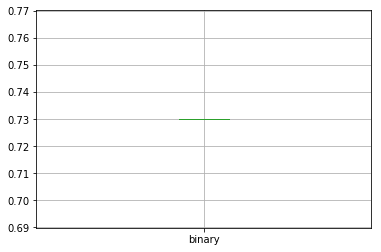

In [45]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
# for mode in modes:
for mode in ['binary']:
	# prepare data for mode
	Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
	# evaluate model on data for mode
	results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()